# **Word2Vec** - Skipgram Models for Learning Word Embeddings

In lecture, we've been looking at language modeling - namely, given some context words, predict the next word in the sequence. While this task is useful in and of itself, in recent years, one of the biggest reasons to do language modeling is to **learn effective, vector representations of the words in our vocabulary**.

These representations, or word embeddings, capture the inherent distribution of words in commonly occuring language by mapping words or phrases to a corresponding vector of real numbers (hence the name, word2vec). There are several advantages of having these vector representations:

- They are easier for a model to digest 
- They capture more contextual information in a lower dimensional space (compared to say, the bag of words approach)

Visualizing some word-vector representations in a scatter plot (of arbitrary vocabulary):

<img src="https://drive.google.com/uc?export=view&id=1k7shuS9Kig5ilZ2a1dHoQEQ44fRYmKWC
" height="500" width="750">

The hope is by observing what words occur together, we can extract some notion of *meaning* with our word embeddings. We can then transfer these meaningful embeddings across different tasks, to accelerate learning. 

Each word in our vocabulary is assigned a unique word embedding, which is essentially a feature vector, such that **words that are semantically similar will be assigned word embeddings that are nearby in our word embedding feature space**. 

In this lab, we'll create a specific model for learning & creating word embeddings: the **Skipgram Model**.

## Loading a Simple Corpus ##

Go back to the folder and make a copy of `corpus.txt` so that it exists in your own Drive. If you just make a copy, we have filled in the path to the file below for you. You may need to change the path for the corpus, or you will get a "No such file or directory" error.
Run the following code to load in the corpus and print the first 10 sentences.

**This stage will ask you to grant mounting access via Google Drive**

In [37]:
## Load Corpus
from google.colab import drive 
drive.mount('/content/drive', force_remount=True) 

## This is the file path for TAs. Students will have to make a copy and then put in the file path themselves.
drive_path="lab5"
with open(f'/content/drive/My Drive/corpus.txt', 'r') as f:
    sentences = f.read().split('.\n')
    
## Print the first 10 sentences
for s in sentences[:10]: 
    print(s)

Mounted at /content/drive
John travelled to the hallway 
Mary journeyed to the bathroom 
John travelled to the hallway 
Mary journeyed to the bathroom 
Daniel went back to the bathroom 
John moved to the bedroom 
John travelled to the hallway 
Mary journeyed to the bathroom 
Daniel went back to the bathroom 
John moved to the bedroom 


### **[Check-off 1]**: Examining the Corpus ###

Above, we have some simple code to read in and print some of the sentences of the corpus. The corpus we'll be dealing with today consists of above 1000 sentences.

For the checkoff, note some of the common characteristics of the sentences. **What words are similar? In particular, what words do you think are _semantically_ similar (nearby in the word embedding space)?**

## What are Skipgrams? ##

Recall our goal: we want word embeddings that effectively capture *meaning* of words. What does *meaning* actually *mean*?

Consider the following sentences: 

```
"The quick brown fox jumps over the lazy dog."
"The lazy dog jumps over the quick brown fox."
"The quick fox jumps over the lazy brown fox."
```

Let's assume we didn't know anything about language, or what any of these words mean. Looking at individual words, we can't glean much meaning. However, **in context** we might be able to learn how certain words operate. 

Consider the words "quick" and "lazy" in the above sentences. We see they occur near one of "fox" or "dog" and perhaps can conclude they are modifiers for "fox" or "dog". 

If we had more and more sentences with "quick" and "lazy", it would become easier and easier to extract meaning from their context.

With Skip-Grams, we model meaning by looking at **windows** of words, essentially looking at a group of words in context. Given a window and a word in that window, our training objective then becomes to predict all the words in the given window.

The following picture demonstrates this windowing method, generating a training set with a window size of 2:

<img src="https://drive.google.com/uc?export=view&id=1xrNYGpBuENYZ1KphnyHooI2xhrl2sYNP" height="450" width="700">
</img>

**Source:** https://towardsdatascience.com/word2vec-skip-gram-model-part-1-intuition-78614e4d6e0b

Given a word in a window, our task is to generate a probability distribution for all words in our vocabulary, representing the chance that a given vocab word is within the window. 

We can achieve this in a pretty weird formulation, predicting the neighboring words with 100% accuracy. Let's give an example:

For the fourth word 'Fox', have the network $h$ try to predict the following examples: 
> $h(fox) = quick$ <br>
> $h(fox) = brown$ <br>
> $h(fox) = jumps$ <br>
> $h(fox) = over$

The network will never be able to predict the one-hot encoding probabilities exactly since the objective for a given input keeps changing, but it will try its best. When optimizing our loss for this, the words that are in the window the most often will end up settling with higher probabilities on average. 

If, for example, we have a future sentence 
> "The quick red **fox** hops over the turtle"

the network will try to predict $h(fox) = quick$ and $h(fox) = over$, thereby reinforcing the prediction. It will not reinforce *brown* or *jumps* and will enforce *red* and *hops*, thereby lowering the probability of their overall predictions.

## Generating Skipgrams

Let's generate our training data. Using the picture above as a reference, fill in the code below with the necessary expression to generate the skipgram data. Note that `WINDOW_SIZE` is a parameter.

In [38]:
from collections import Counter
import numpy as np

In [39]:
print(sentences[0])   # John travelled to the hallway
vocab = Counter("".join(sentences[0]).split())  # Counter({'John': 1, 'hallway': 1, 'the': 1, 'to': 1, 'travelled': 1})  # counter counts the number of instances 
a = list(vocab)  # ['John', 'travelled', 'to', 'the', 'hallway']
word2id = {w:i for i,w in enumerate(a)}  # {'John': 0, 'hallway': 4, 'the': 3, 'to': 2, 'travelled': 1}
word2id['to']

John travelled to the hallway 


2

In [40]:
list1 = ['x','y','z','x','x','x','y', 'z']
Counter(list1)

Counter({'x': 4, 'y': 2, 'z': 2})

In [41]:

## Set window size
WINDOW_SIZE = 2

# ## Build Vocabulary (word id's)
# vocab = "".join(sentences);                         print(len(vocab), vocab[:100])
# vocab = vocab.split();                              print(len(vocab), vocab[:10])
# ## vocab = set(vocab);                              print(len(vocab), vocab)   ## Loses ordering
# vocab = Counter(vocab);                             print(len(vocab), vocab)   ## Keeps ordering
# word2id = {w:i for i,w in enumerate(list(vocab))};  print(len(word2id), word2id, '\n')

vocab = Counter("".join(sentences).split()) 

word2id = {w:i for i,w in enumerate(list(vocab))}    # word2id is similar to the index bank we have in the lecture 
print(word2id)


## Split sentences into words as the for loop iterates through it
s = map(lambda x: x.split(), sentences)
# map(function, iterable[, iterable1, iterable2,..., iterableN])



## TODO: Create Skipgram Data => Fill in Question Mark to Check-Off
data = []
for sentence in s:
    # print(sentence) 
    # print(len(sentence))
    for word_index, word in enumerate(sentence):   
        # print(f'word_index: {word_index}')
        # print(f'word: {word}')
        """
        ['Sandra', 'travelled', 'to', 'the', 'garden']
        word_index: 0
        word: Sandra
        word_index: 1
        word: travelled
        word_index: 2
        word: to
        word_index: 3
        word: the
        word_index: 4
        word: garden
        """  

        min_idx = max(word_index - 2, 0)     ## TODO - hint: use max() to bind
        max_idx = min(word_index + 2, len(sentence)-1)   ## TODO - hint: use min() to bind

        for nb_word in sentence[min_idx:max_idx + 1]:     # we need to add 1 to max_idx because 3:5 can't access 5, only accessing the 3 and 4
            ## TODO: Accumulate entries into data
            if nb_word != word:
              data.append([word2id[word], word2id[nb_word]])  # we append the index in the index bank to make sure the index doesn't change when the word is in 
                                                              # different location of the sentence 
                
print(f"Data [len: {len(data)}] = \n  {data[:9]}...")

{'John': 0, 'travelled': 1, 'to': 2, 'the': 3, 'hallway': 4, 'Mary': 5, 'journeyed': 6, 'bathroom': 7, 'Daniel': 8, 'went': 9, 'back': 10, 'moved': 11, 'bedroom': 12, 'Sandra': 13, 'kitchen': 14, 'garden': 15, 'office': 16}
Data [len: 14608] = 
  [[0, 1], [0, 2], [1, 0], [1, 2], [1, 3], [2, 0], [2, 1], [2, 3], [2, 4]]...


#### **[Check-Off 2]:** Expected output matches
```
Data [len: 14608] = 
  [[0, 1], [0, 2], [1, 0], [1, 2], [1, 3], [2, 0], [2, 1], [2, 3], [2, 4]]...
```

## Building our Skipgram Model ##

Now that we have all the data processed, we can build our Skip-Gram model. It's really simple and uses a lot of the ideas we've already used so far.

We take as input a single word ID and output another predicted word in the same window. We need an embedding layer and our final output softmax as usual. Let's code it up, and train our model!

#### **NOTES:**

- Please implement the skipgram model in **two ways**: 
  - When `manual = True`, use `tf.Variable` directly and take advantage of [`tf.nn.embedding_lookup()`](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup).
  - When `manual = False`, use [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) and other Keras layer as needed.

- Note that we've provided you with a set `vocabulary size` and `embedding size`.
  - **vocabulary size** is  number of unique words in your training corpus. 
  - **embedding size** is the dimensionality of your feature space, where each entry in your word embedding represents a single feature.

- In general, the larger your embedding size, the more "rich" and semantically meaningful your embedding representation will be. This only holds true up to a certain embedding size though, and there does exist a notion of an "ideal" embedding size. Increasing embedding size past this will only introduce meaningless features (noise) and won't improve the loss or accuracy of your language model. 

- Don't worry too much about `@tf.autograph.experimental.do_not_convert`. It's necessary because we want to use only a subset of trainable variables in our model, which the TF graph structure has a hard time reasoning about. 

In [42]:
import numpy as np
print(len(word2id))
print(data)

17
[[0, 1], [0, 2], [1, 0], [1, 2], [1, 3], [2, 0], [2, 1], [2, 3], [2, 4], [3, 1], [3, 2], [3, 4], [4, 2], [4, 3], [5, 6], [5, 2], [6, 5], [6, 2], [6, 3], [2, 5], [2, 6], [2, 3], [2, 7], [3, 6], [3, 2], [3, 7], [7, 2], [7, 3], [0, 1], [0, 2], [1, 0], [1, 2], [1, 3], [2, 0], [2, 1], [2, 3], [2, 4], [3, 1], [3, 2], [3, 4], [4, 2], [4, 3], [5, 6], [5, 2], [6, 5], [6, 2], [6, 3], [2, 5], [2, 6], [2, 3], [2, 7], [3, 6], [3, 2], [3, 7], [7, 2], [7, 3], [8, 9], [8, 10], [9, 8], [9, 10], [9, 2], [10, 8], [10, 9], [10, 2], [10, 3], [2, 9], [2, 10], [2, 3], [2, 7], [3, 10], [3, 2], [3, 7], [7, 2], [7, 3], [0, 11], [0, 2], [11, 0], [11, 2], [11, 3], [2, 0], [2, 11], [2, 3], [2, 12], [3, 11], [3, 2], [3, 12], [12, 2], [12, 3], [0, 1], [0, 2], [1, 0], [1, 2], [1, 3], [2, 0], [2, 1], [2, 3], [2, 4], [3, 1], [3, 2], [3, 4], [4, 2], [4, 3], [5, 6], [5, 2], [6, 5], [6, 2], [6, 3], [2, 5], [2, 6], [2, 3], [2, 7], [3, 6], [3, 2], [3, 7], [7, 2], [7, 3], [8, 9], [8, 10], [9, 8], [9, 10], [9, 2], [10, 8],

In [43]:
a = np.array(data)
print(a)
print()
print(a[:,0])
print(a[:,[0]])
print(a[:,[0]].shape)
print(a[:,[1]].shape)

[[ 0  1]
 [ 0  2]
 [ 1  0]
 ...
 [ 3 15]
 [15  2]
 [15  3]]

[ 0  0  1 ...  3 15 15]
[[ 0]
 [ 0]
 [ 1]
 ...
 [ 3]
 [15]
 [15]]
(14608, 1)
(14608, 1)


In [44]:
import tensorflow as tf


class Word2VecModel(tf.keras.Model):

    def __init__(self, vocab_size, embed_size, manual=True, **kwargs):

        super().__init__(**kwargs)
        self.__manual = manual   ## Semi-hidden variable declaration 

        def make_vars(*dims, initializer=tf.random.normal): 
            return tf.Variable(initializer(dims, stddev=.1))

        if self.__manual:       ## Manual non-layer version
            self.E = make_vars(vocab_size, embed_size)               # E means embedding, the dimensionality of our embedding
            self.W = make_vars(embed_size, vocab_size)               # weight
            self.b = make_vars(vocab_size)               # bias 

        else:                   ## Simple layered version
            self.emb = tf.keras.layers.Embedding(vocab_size, embed_size)             # emb represents the embedding in keras
            self.mlp = tf.keras.layers.Dense(vocab_size)                             # mlp represents multi-layer perceptron, which is the dense layer 
            # for tf.keras.layers.Dense, I don't have to specify the input, just the output(vocab_size)

    # TODO: Build Inference Pipeline
    @tf.autograph.experimental.do_not_convert
    def call(self, inputs, training=True):
        # print(inputs): inputs are the indices of the training samples in the word2id (vocabulary bank)
        print(f'this is inputs.shape: {inputs.shape}')   # (128, 1)

        

        if self.__manual:       ## Manual non-layer version
            ## Use tf.nn.embedding_lookup to perform a lookup in the 
            ## embedding matrix and return the embeddings of words
            ## (or in simple terms the vector representation of words)

            embed_lookup = tf.nn.embedding_lookup(self.E, inputs) # (inputs, embed_size)
            # self.E is the embedding matrix 
            # inputs contains the ids to be looked up in the embedding matrix(self.E)

            dense = tf.matmul(embed_lookup, self.W) + self.b  
            # (inputs, embed_size) x (embed_size, vocab_size) + (vocab_size)
            # = (inputs, vocab_size)
            # = (batch_size, vocab_size)

            logits = dense  

            print(f'this is logits.shape: {logits.shape}')     # (128, 1, 17)
        
        else:                   ## Simple layered version
            embed_layer = self.emb
            embed_output = embed_layer(inputs)   # find the embeddings for the inputs
            # inputs.shape: (batch_size, 1)
            
            print(f'this is shape of embed_output: {embed_output.shape}')
            # embed_output.shape: (128, 1, 30)
            # (batch_size, embed_size)
            # each row is the embedding for one word in the batch_size. 

            mlp_layer = self.mlp
            logits = mlp_layer(embed_output)     # calculate the dense layer (weights and biases)

            print(f'this is shape of logits: {logits.shape}')
            # (128, 1, 17)
            #  128 rows, in each row contains [17 entries]
            # (batch_size, vocab_size)
            # each entry of the row contains the unsoftmax probability for the word in the total vocabulary bank 
        
        return logits 


model = Word2VecModel(
    vocab_size = len(word2id), 
    embed_size = 30,
    manual = True      ## TODO: Make sure both True and False work
)

model.compile(
    # configures the model for training
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits,  # use to calculate the loss
    metrics = [],   # we don't want to calculate the accuracy so we don't have the metrics specified 
    run_eagerly = True
)


model.fit(
    # model.fit is for training the model with the given inputs (and corresponding training labels) 
    x = np.array(data)[:, [0]],   # x is the inputs in the call function(training samples)   # first column
    y = np.array(data)[:, [1]],   # y is the label                                           # second column 
    epochs = 20,
    batch_size = 128,
);

Epoch 1/20
this is inputs.shape: (128, 1)
this is logits.shape: (128, 1, 17)
  1/115 [..............................] - ETA: 4s - loss: 2.8515this is inputs.shape: (128, 1)
this is logits.shape: (128, 1, 17)
this is inputs.shape: (128, 1)
this is logits.shape: (128, 1, 17)
this is inputs.shape: (128, 1)
this is logits.shape: (128, 1, 17)
this is inputs.shape: (128, 1)
this is logits.shape: (128, 1, 17)
  5/115 [>.............................] - ETA: 1s - loss: 2.8504this is inputs.shape: (128, 1)
this is logits.shape: (128, 1, 17)
this is inputs.shape: (128, 1)
this is logits.shape: (128, 1, 17)
this is inputs.shape: (128, 1)
this is logits.shape: (128, 1, 17)
  8/115 [=>............................] - ETA: 1s - loss: 2.8450this is inputs.shape: (128, 1)
this is logits.shape: (128, 1, 17)
this is inputs.shape: (128, 1)
this is logits.shape: (128, 1, 17)
this is inputs.shape: (128, 1)
this is logits.shape: (128, 1, 17)
 11/115 [=>............................] - ETA: 1s - loss: 2.8430thi

In [45]:
a = np.array([[1,2],
              [4,5],
              [7,8]])
print(a)

b = tf.Variable(tf.random.normal([2], stddev=.1))
b.numpy()

c = a + b
c

[[1 2]
 [4 5]
 [7 8]]


<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1.0688349, 1.9650148],
       [4.068835 , 4.965015 ],
       [7.068835 , 7.965015 ]], dtype=float32)>

#### **[Check-Off 3]:** Final Loss < 1.9

## Visualizing Embeddings ##

In the following blocks of code, we're going to test some attributes of our embeddings to see what kinds of information they contains. 

The following utility computes how similar various words in our vocabulary are based off of our optimization routine: 

In [46]:
## Load Embeddings, define id2word
if hasattr(model, 'E'): embeddings = model.E.read_value()
else:                   embeddings = model.emb.get_weights()[0]

id2word = {i: w for w, i in word2id.items()}

## Define Helper Functions
## Calculate euclidean distance between two vectors
def euclidean_dist(vec1, vec2):
    return np.sqrt(np.sum((vec1-vec2)**2))

## Return the id of the word with smallest euclidean distance to the queried word(index)
def find_closest(word_index, vectors):
    min_dist = 10000    # to act like positive infinity
    min_index = -1
    query_vector = vectors[word_index]
    for index, vector in enumerate(vectors):
        if euclidean_dist(vector, query_vector) < min_dist and not np.array_equal(vector, query_vector):
            min_dist = euclidean_dist(vector, query_vector)
            min_index = index
    return min_index

Print the list of words.

In [47]:
print("List of words:" + "\n  " + "\n  ".join(word2id.keys()))

List of words:
  John
  travelled
  to
  the
  hallway
  Mary
  journeyed
  bathroom
  Daniel
  went
  back
  moved
  bedroom
  Sandra
  kitchen
  garden
  office


Choose two words from above to put in the following call to see what's closest!

In [48]:
interest_words = ["John", "went"]  ## TODO
for word in interest_words: 
    closest_id = find_closest(word2id[word], embeddings)
    print(f'Closest word to {word}:', id2word[closest_id])

Closest word to John: Mary
Closest word to went: journeyed


Finally, we're going to use a technique called [PCA (Principle Component Analysis)](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html) to visualize the relationship of the word embeddings in 2D space. The points that are closest together are the ones that cluster into a similar group based on the known data. If you are interested, we'd recommend [skimming over this nice tutorial](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html) or taking a Machine Learning course where this is covered in more detail. 

This will use scikit-learn, which is a very common machine learning library. You'll be using it a lot if you go into data science. We've also included t-SNE if you wanted to try it (probably not as good). To learn a bit more about how these differ, feel free to check out [this G2G article](https://www.geeksforgeeks.org/difference-between-pca-vs-t-sne/).

Running the below code should give you a very large graph with some visible clustering!

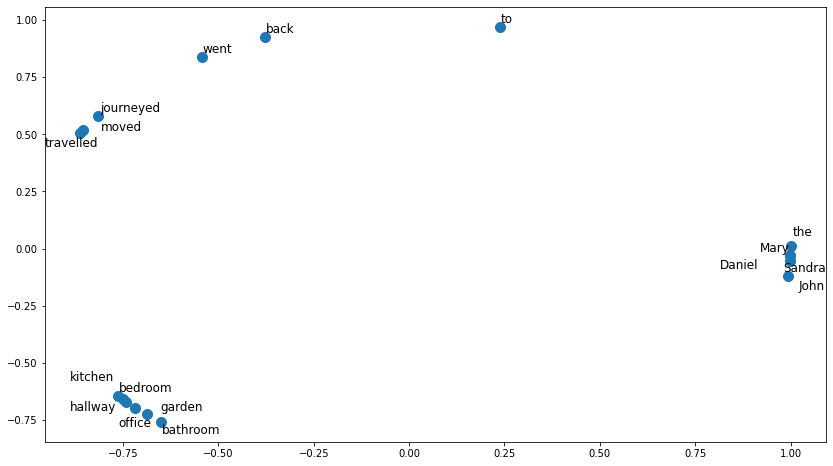

In [49]:
import matplotlib.pyplot as plt

## Importing Scikit-Learn, a very useful machine learning library
from sklearn.manifold import TSNE 
from sklearn import preprocessing
from sklearn.decomposition import PCA

## Somebody made a library for spacing out plot labels, so we'll just use it
try: 
    from adjustText import adjust_text
except: 
    !pip install adjustText -q 
    from adjustText import adjust_text

## reduce dimenion from 30 to 2
pca = PCA(n_components=2) # Usually PCA > TSNE for large dimension like 30 :)
vectors = pca.fit_transform(embeddings)

## Normalize the results so that we can view them more comfortably in matplotlib
normalizer = preprocessing.Normalizer()
norm_vectors = normalizer.fit_transform(vectors, 'l2')

def viz_scatter_plot(points, labels, figsize=(14,8), spaced_out=True):
    ## plot the 2D normalized vectors
    xs = [point[0] for point in points]
    ys = [point[1] for point in points]

    f, axs = plt.subplots(1, 1, figsize=(14,8))
    plt.scatter(xs, ys, s=100)

    if not spaced_out:     ## Normal way of visualizing plots
        for i, label in enumerate(labels):
            x, y = points[i]
            plt.annotate(label, (x, y))
    
    else:                  ## Using the spacing-out utility
        texts = [plt.text(x, y, word, size='large') for x, y, word in zip(xs, ys, labels)]
        adjust_text(texts, x=xs, y=ys, force_points=0.1)  ## library adjusts xs/ys in-place

viz_scatter_plot(
    points = [norm_vectors[word2id[v]] for v in word2id],
    labels = word2id
)

#### **[Check-Off 4]** Show your TA your final graph and results. 

1. What are some examples of clustering (or lack of clustering) that you notice? Anything weird or interesting?

2. Vizualizing the 2-D clustering of the embeddings (using PCA) is one example of a downstream task using the embeddings we produced. 
  - What are some ways that we can use the clustering we created?
  - Can you think of any other examples of downstream tasks or use cases for embeddings?



## **[BONUS Check-off]** (if you have the time) 

----

### **Question 1: Bottle-Necking The Latent Space**

In our scatterplot visualization section, we used PCA cluster our vectors into groups in 2D space. PCA is an example of **dimensionality reduction**, which is a technique that condenses a high-dimensional representation of data down to a lower-dimensional version that tries to maintain the differentiating properties of the original data.

PCA uses linear algebra (specifically, matrix diagonalization) to perform this reduction, and this is out of scope for our class. HOWEVER, what *is* in scope of the class is the use of *network bottlenecking* to achieve a similar result. 

We'll have a whole unit on this (**autoencoders**) because there are a lot of interesting ways of doing this, but you actually already have the skills to implement the most basic kind on your own if you'd like!

You can implement a model that minimizes the loss function 

> $Encoder : \mathbb{R}^n \to \mathbb{R}^\ell$ <br/>
> $Decoder : \mathbb{R}^\ell \to \mathbb{R}^n$ <br/>
> $\mathcal{L}_{autoencoder}(x) = \mathcal{L}(x, Decoder(Encoder(x)))$ <br/>

When $\ell = 2$, the bottlenecked representation will be a 2D input, and then $Encoder(x)$ can be plotted on a 2D plane. 

<img src="https://www.compthree.com/images/blog/ae/ae.png" height="400" width="500"></img>

**Source:** https://www.compthree.com/blog/autoencoder/

#### **Fun Fact: *You can already do this!***

In fact, it briefly made a cameo in the Lab 3 complementary content! Go ahead and implement it for your model and use `viz_scatter_plot` to visualize the output of the encoder. 

### **HINTS**: 
 - You can just a one or two dense layers in each of your encoder and decoder. 
 - Remember that Sequential models function as optimizable components, in that you can have several training together automatically. 
 - **This is actually a chill exercise! Try it out!**

In [53]:
class VectorAE(tf.keras.Model):

    def __init__(self, embed_size, bottleneck_size=2, **kwargs):
        super().__init__(**kwargs)
        
        self.encoder = tf.keras.Sequential([    ## TODO
        tf.keras.layers.Dense(bottleneck_size)
        ])
        self.decoder = tf.keras.Sequential([    ## TODO
        tf.keras.layers.Dense(embed_size)
        ])

    def call(self, inputs, training=True):
        encoder_output = self.encoder(inputs)
        decoder_output = self.decoder(encoder_output)
        inputs = decoder_output
        return inputs     


if hasattr(model, 'E'): embeddings = model.E.read_value()
else:                   embeddings = model.emb.get_weights()[0]

id2word = {i: w for w, i in word2id.items()}

ae_model = VectorAE(
    embed_size = 30,       ## TODO
    bottleneck_size = 2,  ## TODO
)

ae_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    loss = tf.keras.losses.MSE
)

ae_model.fit(
    x = embeddings,   
    y = embeddings,   # we want the labels and inputs to be the same
    epochs = 10,
    batch_size = 5,       ## I wonder why would a small batch size would help?

);

Epoch 1/10
4/4 [==============================] - 0s 4ms/step - loss: 0.2806
Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2111
Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1801
Epoch 4/10
4/4 [==============================] - 0s 4ms/step - loss: 0.1629
Epoch 5/10
4/4 [==============================] - 0s 4ms/step - loss: 0.1522
Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1406
Epoch 7/10
4/4 [==============================] - 0s 4ms/step - loss: 0.1300
Epoch 8/10
4/4 [==============================] - 0s 4ms/step - loss: 0.1201
Epoch 9/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1112
Epoch 10/10
4/4 [==============================] - 0s 4ms/step - loss: 0.1014


And then to visualize the points...

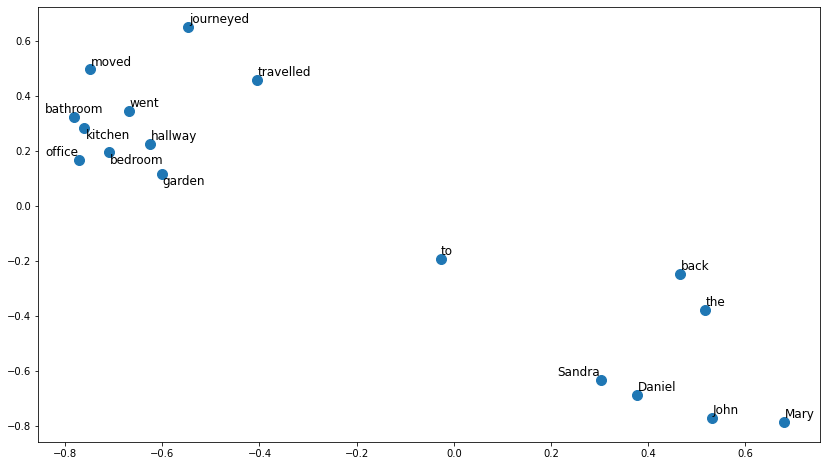

In [54]:
encodings = [ae_model.encoder(tf.expand_dims(emb, 0))[0] for emb in embeddings]

viz_scatter_plot(
    points = encodings,
    labels = word2id
)

----

### **Question 2: Matrix Factorization**

A slightly more difficult problem which can be solved quite intuitively with item2vec involves movie recommendations. 

**Scenario:** We have a list of users and a list of movies, and we have some known reviews. We can use item embedding to train to predict the rating of a movie by by training up embedding layers for the user and movie indices. In other words: 

> $h(\text{user index}, \text{movie index}) = \text{Rating}$ 

How might we use the embeddings to go from vector to rating?

#### **HINT**: 
 - I wonder who came up with the title of the question...?

----